## BI-LSTM MODEL

This notebook introduces a Bidirectional LSTM model to capture both past and future context in text sequences to improve upon the LSTM model

<!-- --- -->

In [8]:
import numpy as np
import os 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ARTIFACTS_PATH = "../artifacts"

In [3]:
VOCAB_SIZE = 5000 
MAX_LEN = 200
NUM_CLASSES = 5

LOADING ARTIFACTS

In [4]:
def load_padded_sequences():
    X_train_pad = np.load(os.path.join(ARTIFACTS_PATH, "X_train_pad.npy"))
    X_test_pad = np.load(os.path.join(ARTIFACTS_PATH, "X_test_pad.npy"))

    return X_train_pad, X_test_pad


def load_labels():
    y_train = np.load(os.path.join(ARTIFACTS_PATH, "y_train.npy"))
    y_test = np.load(os.path.join(ARTIFACTS_PATH, "y_test.npy"))

    return y_train, y_test



X_train_pad , X_test_pad = load_padded_sequences()
y_train, y_test = load_labels()


In [5]:
with open("/Users/sarthaksharna/AutoNews/artifacts/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

<!-- -- -->

CREATING THE MODEL ARCHITECTURE

In [ ]:
def create_bilstm_model():
    """This function creates a simple bilstm model."""

    model = Sequential(
        [
            Input(shape = (MAX_LEN ,)),
            Embedding(input_dim = VOCAB_SIZE, output_dim = 128),
            Bidirectional(LSTM(128, return_sequences=False)),
            Dropout(0.5),
            Dense(NUM_CLASSES, activation = "softmax")

        ]
    )

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [12]:
model = create_bilstm_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 904,453 (3.45 MB)

 Trainable params: 904,453 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

TRAINING THE BISLTM MODEL

In [14]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs = 30,
    batch_size = 64,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.2824 - loss: 1.5701 - val_accuracy: 0.4106 - val_loss: 1.5278
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.4162 - loss: 1.4440 - val_accuracy: 0.4370 - val_loss: 1.5342
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.6493 - loss: 1.0130 - val_accuracy: 0.6012 - val_loss: 1.0390
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.7978 - loss: 0.6059 - val_accuracy: 0.7654 - val_loss: 0.6173
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.8897 - loss: 0.3792 - val_accuracy: 0.7889 - val_loss: 0.5773
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.9279 - loss: 0.2573 - val_accuracy: 0.7038 - val_loss: 0.7318
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.9294 - loss: 0.2303 - val_accuracy: 0.8680 - val_loss: 0.4336
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.9934 - loss: 0.0768 - val_accuracy: 0.

In [15]:
def evaluate_bilstm_model(model, X_test, y_test, label_encoder):
    # Keras evaluation
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))


evaluate_bilstm_model(model, X_test_pad, y_test, le)



Test Loss: 0.2640
Test Accuracy: 0.9061
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

Classification Report:
               precision    recall  f1-score   support

     business       0.94      0.93      0.94       101
entertainment       0.84      0.86      0.85        74
     politics       0.89      0.89      0.89        81
        sport       0.92      0.98      0.95       101
         tech       0.93      0.83      0.88        69

     accuracy                           0.91       426
    macro avg       0.90      0.90      0.90       426
 weighted avg       0.91      0.91      0.91       426


Confusion Matrix:
[[94  2  5  0  0]
 [ 1 64  2  5  2]
 [ 4  3 72  0  2]
 [ 1  1  0 99  0]
 [ 0  6  2  4 57]]


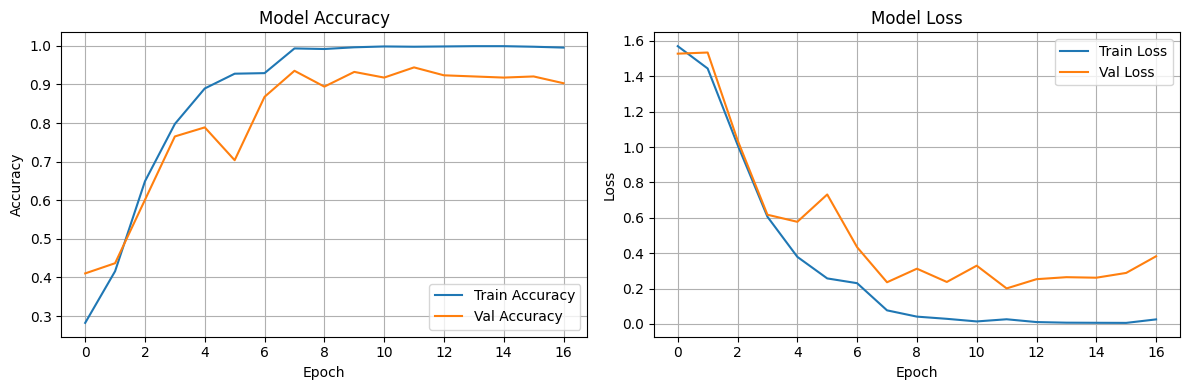

In [16]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<!-- ---- -->

<!-- ----- -->

INFERENCE

The BiLSTM model exhibits a smoother and more stable training and validation curve compared to the tuned LSTM, indicating better learning dynamics and improved contextual representation.

By processing sequences in both forward and backward directions, the model captures richer semantic dependencies, which is reflected in more consistent validation performance.

However, despite the improved training behavior, the overall test accuracy remains similar to the tuned LSTM,
A small gap between training and validation curves still persists, pointing to mild overfitting.

To further improve generalization, techniques such as Spatial Dropout, reducing the number of LSTM units can be explored. These strategies may help regularize the model and extract more discriminative features without increasing model complexity.